In [24]:
# Python 3
# import jpeg as JPEG
import libs.ruidos as ruido
from skimage import io
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import fftpack
from scipy.ndimage import filters


In [2]:
def get_2D_dct(img):
    return fftpack.dct(fftpack.dct(img.T, norm='ortho').T, norm='ortho')

def get_2d_idct(coefficients):
    return fftpack.idct(fftpack.idct(coefficients.T, norm='ortho').T, norm='ortho')

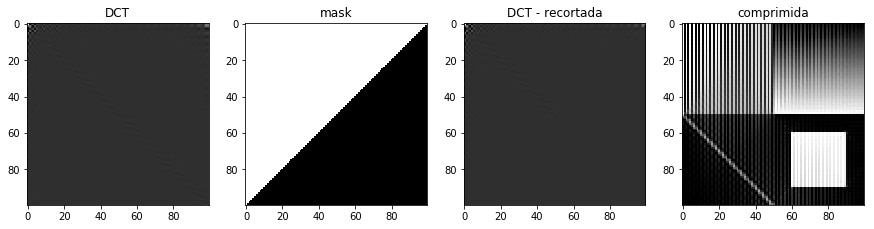

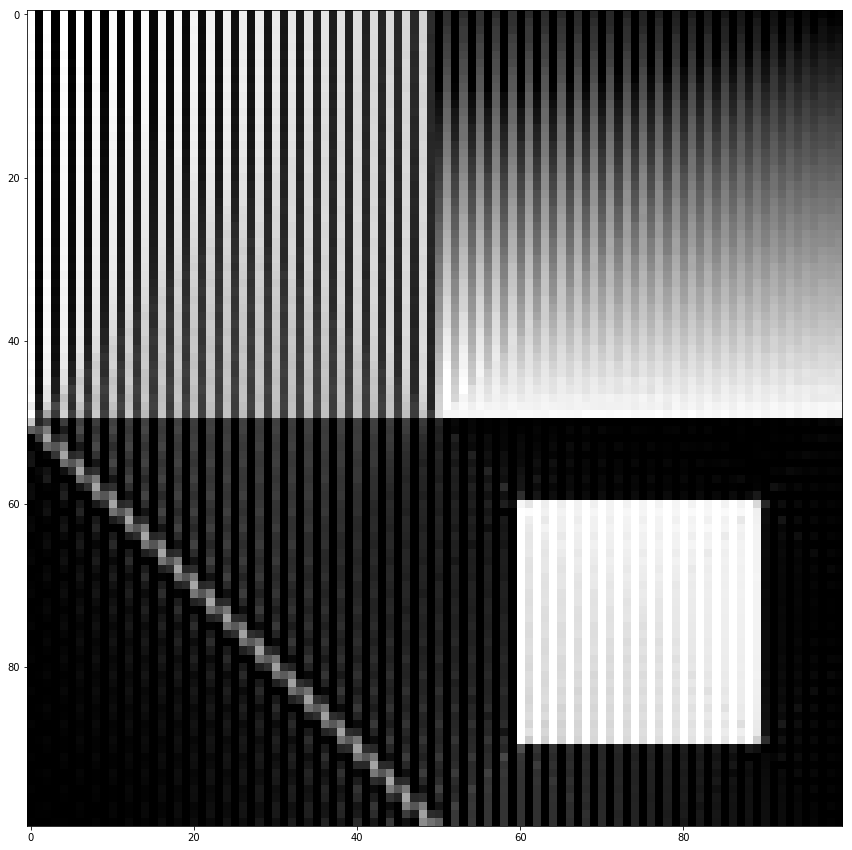

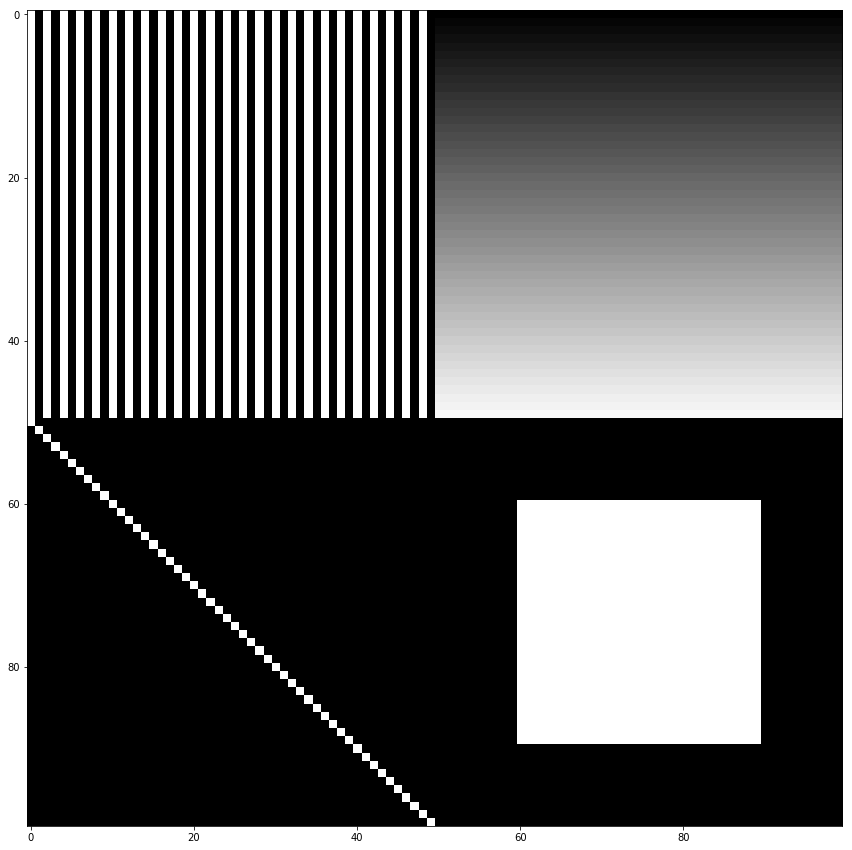

In [8]:
# img = np.transpose(io.imread('bmp/homogenea.bmp'))
img = io.imread('bmp/no_homogenea.bmp')
img_dct = get_2D_dct(img)
io.imsave('latex/fig/no_homogenea.png',img)

# máscara
menores_coef_mask = np.flip(np.tril(np.ones(img.shape),0),0)

img_dct_trimmed = np.multiply(img_dct,menores_coef_mask)
# recorto coeficientes
img2 = get_2d_idct(img_dct_trimmed).clip(0,255).astype('uint8')

# muestro
plt.figure(figsize=(15,15))

plt.subplot(1,4,1)
plt.imshow(img_dct,cmap='gray')
plt.title('DCT')

plt.subplot(1,4,2)
plt.imshow(menores_coef_mask,cmap='gray')
plt.title('mask')

plt.subplot(1,4,3)
plt.imshow(img_dct_trimmed,cmap='gray')
plt.title('DCT - recortada')

plt.subplot(1,4,4)
plt.imshow(img2,cmap='gray')
plt.title('comprimida')

plt.show()

plt.figure(figsize=(15,15))
plt.imshow(img2,cmap='gray')
plt.show()

plt.figure(figsize=(15,15))
plt.imshow(img,cmap='gray')
plt.show()

io.imsave('latex/fig/no_homogenea_comprimida.png',img2)

In [111]:

def get_2D_dct(img):
    return fftpack.dct(fftpack.dct(img.T, norm='ortho').T, norm='ortho')

def get_2d_idct(coefficients):
    return fftpack.idct(fftpack.idct(coefficients.T, norm='ortho').T, norm='ortho')


img = io.imread('bmp/lena.bmp')[:,:,0]
dct_size = img.shape[0]
dct = get_2D_dct(img)
reconstructed_images = []

for ii in range(dct_size):
    dct_copy = dct.copy()
    
#     mask = np.flip(np.tril(np.ones(img.shape),ii-dct_size),0)

#     dct_copy = np.multiply(mask,dct_copy)

    dct_copy[ii:,:] = 0
    dct_copy[:,ii:] = 0

    # Reconstructed image
    reconstructed_image = get_2d_idct(dct_copy)

    # Create a list of images
    reconstructed_images.append(reconstructed_image)

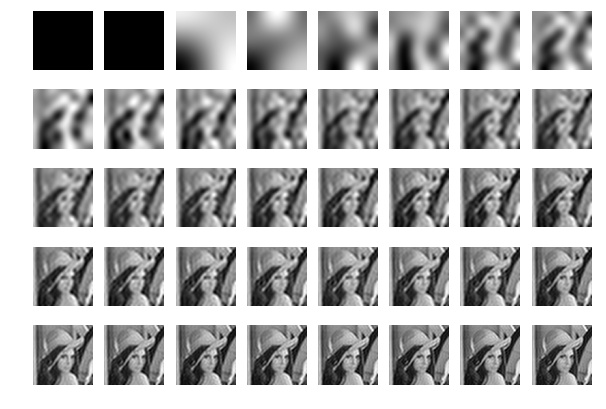

In [126]:
fig = plt.figure(figsize=(10,7))
for ii in range(40):
    plt.subplot(5,8, ii+1)
    plt.imshow(reconstructed_images[ii], cmap='gray')
    plt.axis('off')
#     plt.tight_layout()
plt.savefig('latex/fig/lenas.png',bbox_inches='tight')
plt.show()

io.imsave('latex/fig/lenas_100frecuencias.png',np.array(reconstructed_images[100].clip(0,255),dtype=np.uint8))

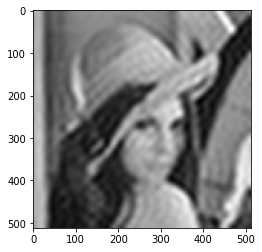

In [120]:
plt.imshow(reconstructed_images[39],cmap='gray')
plt.show()

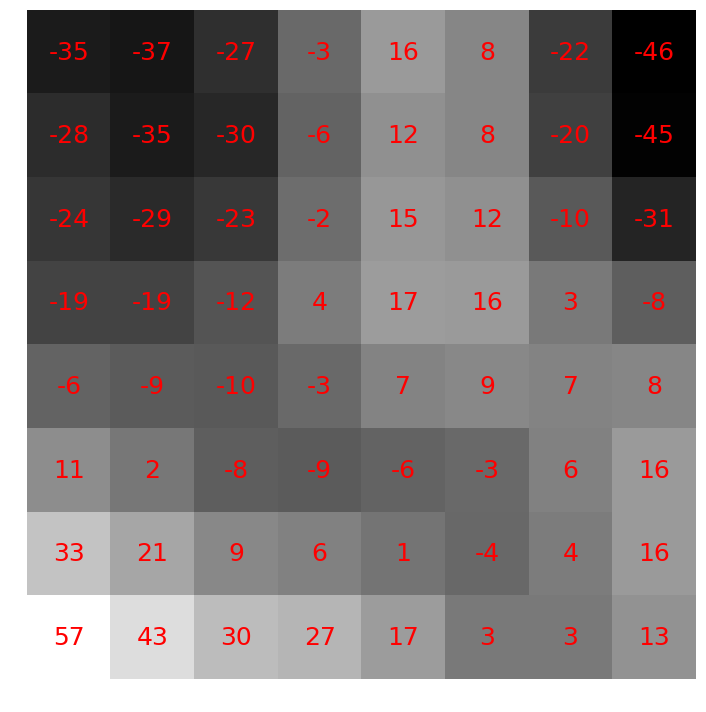

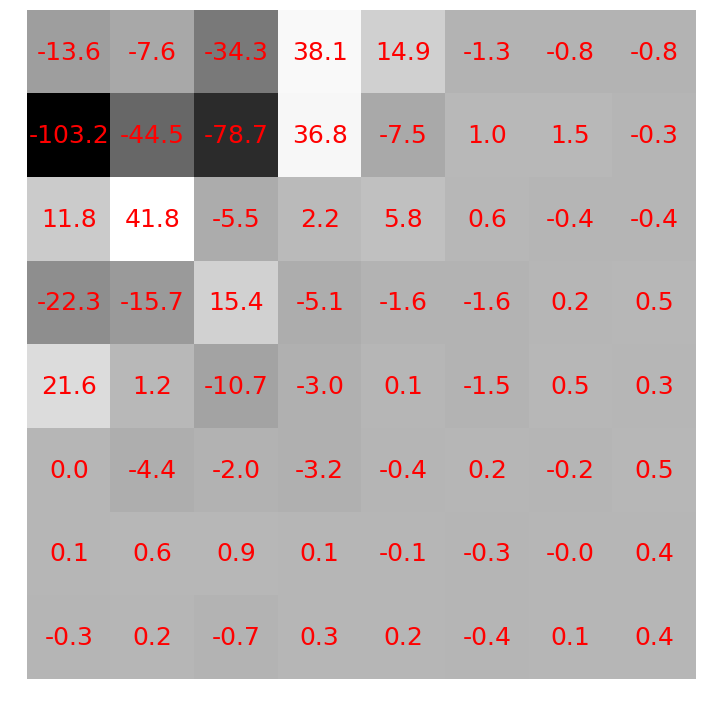

In [82]:
# 8x8 random y su DCT
img = np.array(np.random.rand(8,8)*255,dtype=np.int)
img = filters.gaussian_filter(img, 1.2) -128

dct = get_2D_dct(img)

fig, ax = plt.subplots(figsize=(10,10))
plt.imshow(img,cmap='gray')
for (j,i),label in np.ndenumerate(img):
    ax.text(i,j,label,ha='center',va='center',fontsize=25,color='r')
ax.tick_params(labelsize=20)
plt.axis('off')
plt.tight_layout()
plt.savefig('latex/fig/8x8random.png')
plt.show()
    
fig, ax = plt.subplots(figsize=(10,10))
plt.imshow(dct,cmap='gray')
for (j,i),label in np.ndenumerate(dct):
    ax.text(i,j,"{0:.1f}".format(label),ha='center',va='center',fontsize=25,color='r')
ax.tick_params(labelsize=20)
plt.axis('off')
plt.tight_layout()
plt.savefig('latex/fig/8x8random_dct.png')
plt.show()

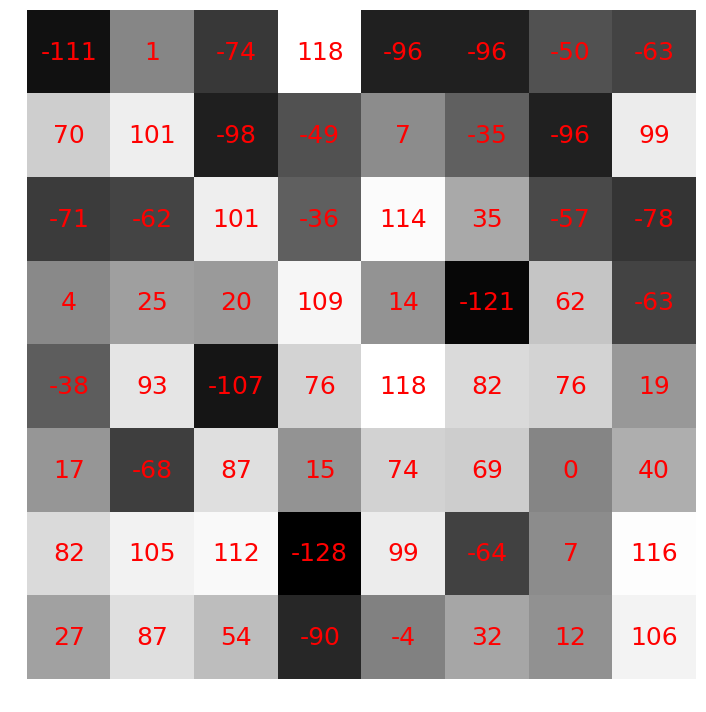

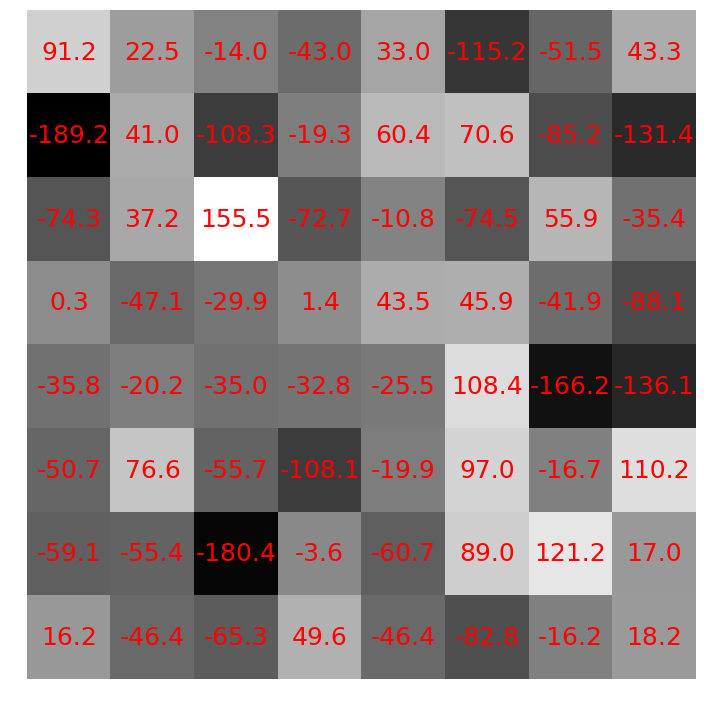

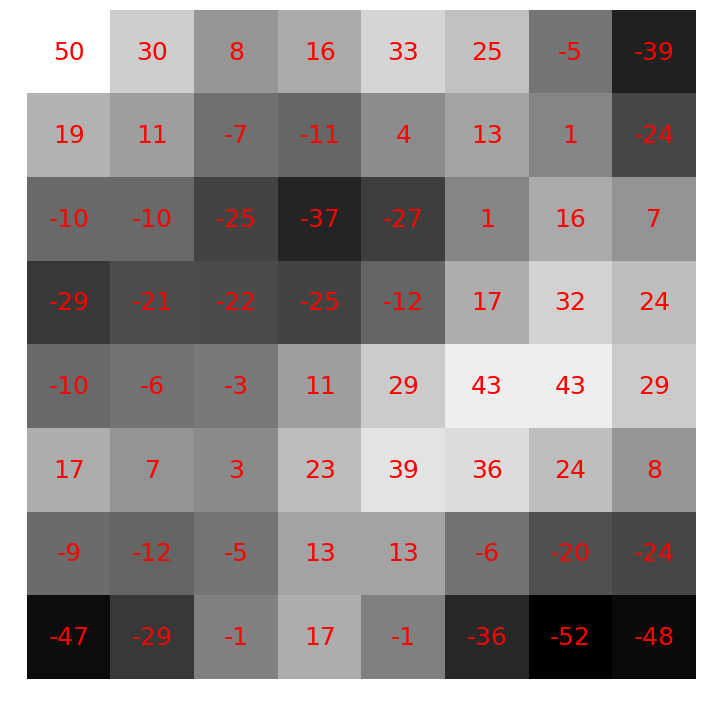

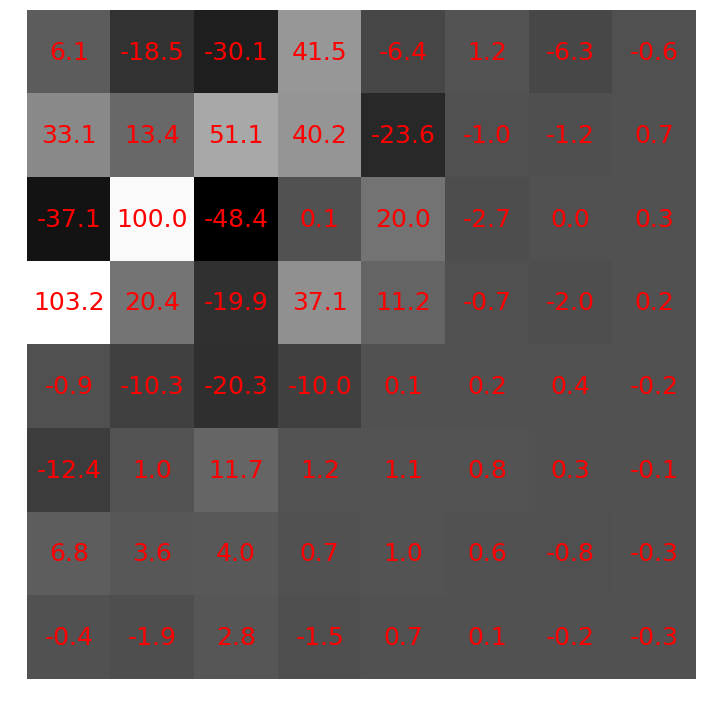

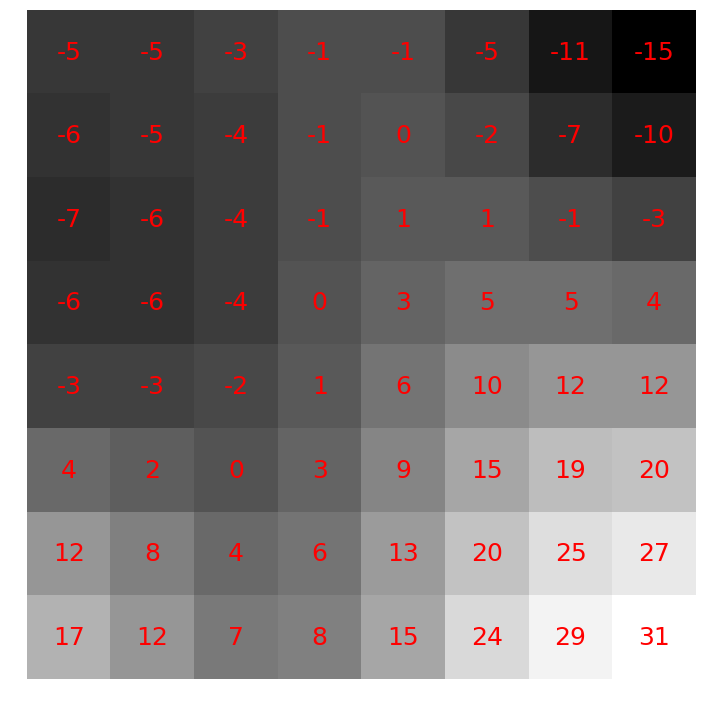

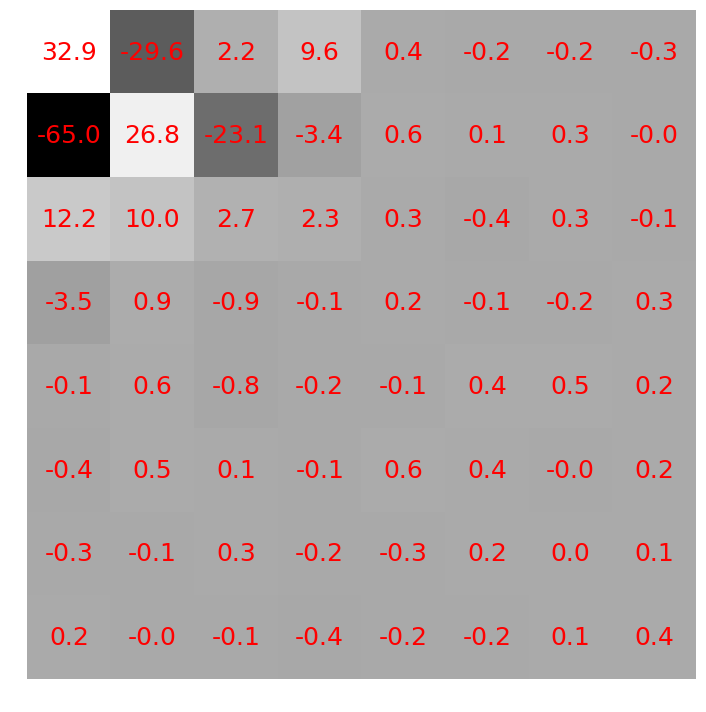

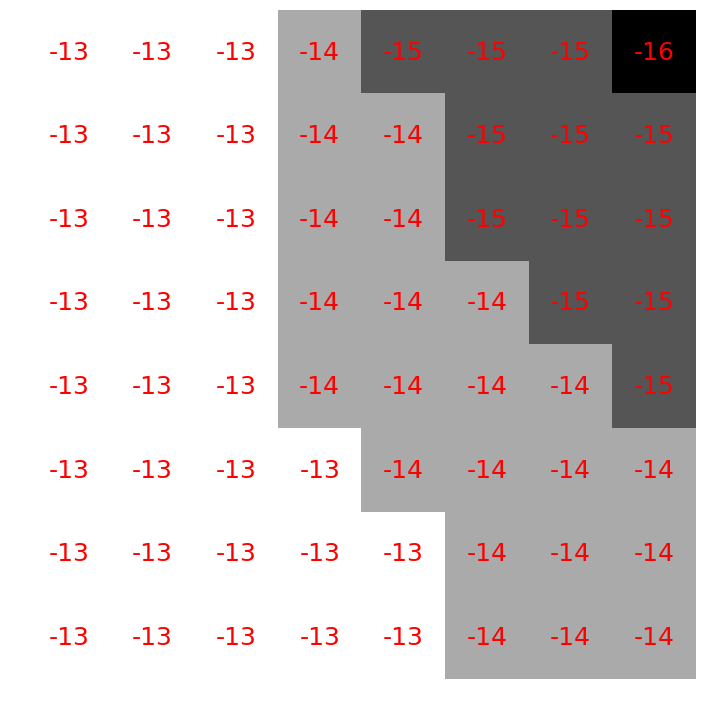

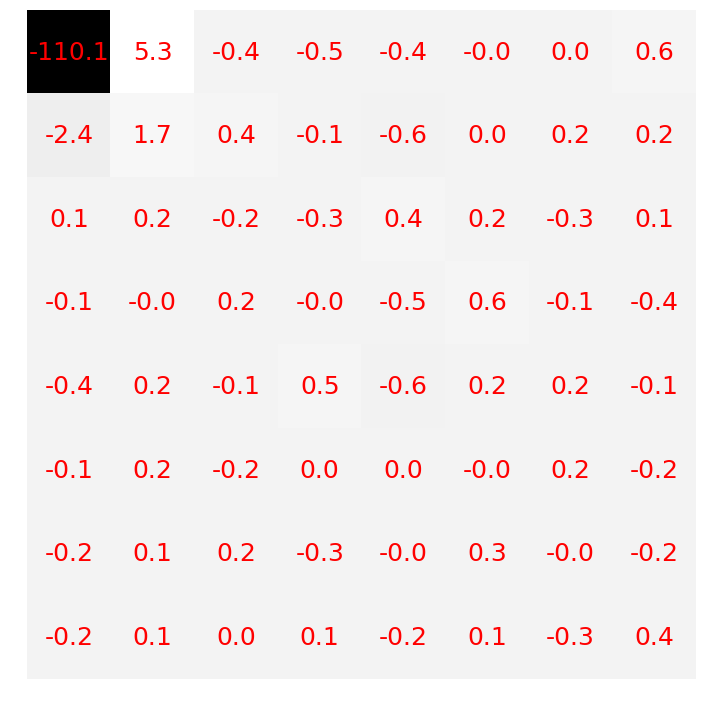

In [81]:
# distintos 8x8 y sus dct
sigmas = [0.1,1,2,5]

n = 0
for sigma in sigmas:

    img = np.array(np.random.rand(8,8)*255,dtype=np.int)
    img = filters.gaussian_filter(img, sigma) -128
    dct = get_2D_dct(img)
    fig, ax = plt.subplots(figsize=(10,10))
    plt.imshow(img,cmap='gray')
    for (j,i),label in np.ndenumerate(img):
        ax.text(i,j,label,ha='center',va='center',fontsize=25,color='r')
    ax.tick_params(labelsize=20)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('latex/fig/8x8random'+str(n)+'.png')
    plt.show()

    fig, ax = plt.subplots(figsize=(10,10))
    plt.imshow(dct,cmap='gray')
    for (j,i),label in np.ndenumerate(dct):
        ax.text(i,j,"{0:.1f}".format(label),ha='center',va='center',fontsize=25,color='r')
    ax.tick_params(labelsize=20)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('latex/fig/8x8random_dct'+str(n)+'.png')
    plt.show()
    n += 1
